In [143]:
import os
import cv2
from skimage import io
from skimage.metrics import structural_similarity
import matplotlib.pyplot as plt
import numpy as np

In [144]:
normPath = 'C:\\Users\\killi\\Computing work\\trains\\trainvis\\ml\\img\\normalisation'
gold = cv2.imread(os.path.join(normPath, 'gold standard.jpg'))

ims = [io.imread(os.path.join(normPath, i)) for i in os.listdir(normPath) if 'gold standard' not in os.path.basename(i)]

greyGold = cv2.cvtColor(gold, cv2.COLOR_BGR2GRAY)
greyIms = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in ims]

# greyGold = cv2.imread(os.path.join(normPath, 'gold standard.jpg'), cv2.IMREAD_GRAYSCALE)
# greyIms = [io.imread(os.path.join(normPath, i), cv2.IMREAD_GRAYSCALE) for i in os.listdir(normPath) if 'gold standard' not in os.path.basename(i)]

In [145]:
def BFMatch(query, gold):
    sift = cv2.SIFT_create()

    queryKP, queryDesc = sift.detectAndCompute(query, None)
    goldKP, goldDesc = sift.detectAndCompute(gold, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(queryDesc, goldDesc, k=2)

    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])

    matchesImg = cv2.drawMatchesKnn(query, queryKP, gold, goldKP, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(matchesImg)
    plt.show()

In [146]:
def BFMatchNorm(query, gold):
    sift = cv2.SIFT_create()

    queryKP, queryFeat = sift.detectAndCompute(query, None)
    goldKP, goldFeat = sift.detectAndCompute(gold, None)

    queryKP = np.float32([kp.pt for kp in queryKP])
    goldKP = np.float32([kp.pt for kp in goldKP])

    bf = cv2.BFMatcher(cv2.NORM_HAMMING2,crossCheck=True)
    matches = bf.match(queryFeat, goldFeat)
    matches = sorted(matches,key=lambda x:x.distance)

    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    queryPts = np.float32([queryKP[m.queryIdx]
                .pt for m in good]).reshape(-1, 1, 2)

    goldPts = np.float32([goldKP[m.trainIdx]
                    .pt for m in good]).reshape(-1, 1, 2)

    matrix, mask = cv2.findHomography(queryPts, goldPts, cv2.RANSAC, 5.0)
    h,w = gold.shape

    result = cv2.warpPerspective(query, matrix, (w,h))
    plt.imshow(result)
    plt.show()

    matches_mask = mask.ravel().tolist()

    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    dst = cv2.perspectiveTransform(pts, matrix)
    # cv2.polylines(query, [np.int32(dst)], True, (255, 0, 0), 3)

    perspectiveM = cv2.getPerspectiveTransform(np.float32(dst),pts)
    found = cv2.warpPerspective(query,perspectiveM,(w,h))

    # plt.imshow(found)
    # plt.show()

In [147]:
## Using ORB for feature mapping

GOOD_MATCH_PERCENT = 0.2

# assumes im1 and im2 are greyscale
def alignImagesORB(im1, im2):

  # # Convert images to grayscale
  # im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  # im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

  # Detect ORB features and compute descriptors.
  orb = cv2.ORB_create() # turn off cap with no args create(MAX_FEATURES), increases accuracy tradeoff time
  keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2, None)

  # Match features.
  # matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  # matches = matcher.match(descriptors1, descriptors2, None)

  bf = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
  matches = bf.match(descriptors1, descriptors2)

  # bf = cv2.BFMatcher_create()
  # matches = bf.knnMatch(descriptors1, descriptors2, k=2)

  #print(np.shape(matches))
  #print(matches)
  # matches = [item for sublist in matches for item in sublist] # only for knn matcher
  matches = list(matches) # for non knn matches

  # Sort matches by score
  matches.sort(key=lambda x: x.distance, reverse=False)

  # Remove not so good matches
  numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:numGoodMatches]

  # Draw top matches
  imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
  # cv2.imwrite("matches.jpg", imMatches)
  plt.imshow(imMatches)
  plt.show()

  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)

  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

  # Find homography
  h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

  # Use homography
  height, width = im2.shape # also expected channels but shape only returns (x,y) o well
  im1Reg = cv2.warpPerspective(im1, h, (width, height))

  return im1Reg, h

In [148]:
def dumbWarp(query, gold):
    qh, qw = query.shape
    gh, gw = gold.shape

    # top-left, top-right, bottom-right, bottom-left
    queryCorners = np.array([[0,0], [qw,0], [qw,qh], [0,qh]], np.int32)
    goldCorners = np.array([[0,0], [gw,0], [gw,gh], [0,gh]], np.int32)

    queryPts = np.float32(queryCorners)
    goldPts = np.float32(goldCorners)

    M = cv2.getPerspectiveTransform(queryPts, goldPts)
    warped = cv2.warpPerspective(query, M, (gw, gh))
    return warped

Transform from img-1.jpg to Gold:
Image before Warping: 


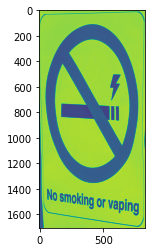

Image After dumb-warping, feature matched to gold standard: 


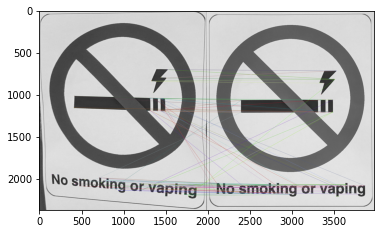

Dumb warp, gold Standard SSIM: 0.7399618418151496
Smart warp, gold Standard SSIM: 0.7615181726874835
Image smart-warped to feature matches: 


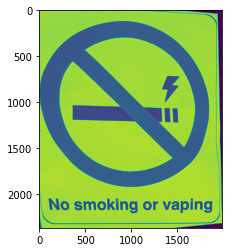

Transform from img-2.jpg to Gold:
Image before Warping: 


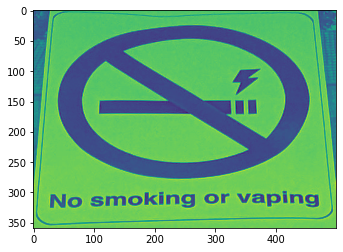

Image After dumb-warping, feature matched to gold standard: 


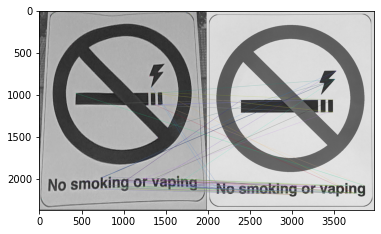

Dumb warp, gold Standard SSIM: 0.657248023380754
Smart warp, gold Standard SSIM: 0.6921933559606902
Image smart-warped to feature matches: 


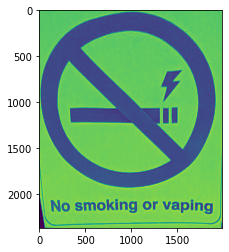

Transform from img-3.jpg to Gold:
Image before Warping: 


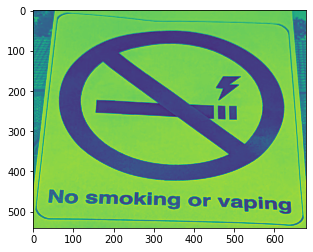

Image After dumb-warping, feature matched to gold standard: 


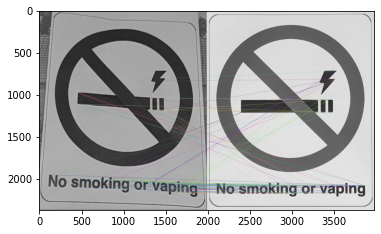

Dumb warp, gold Standard SSIM: 0.6735855385924633
Smart warp, gold Standard SSIM: 0.7303036228483605
Image smart-warped to feature matches: 


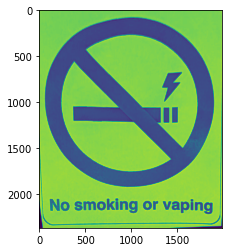

Transform from img-4.jpg to Gold:
Image before Warping: 


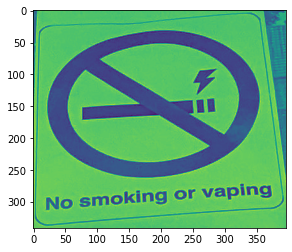

Image After dumb-warping, feature matched to gold standard: 


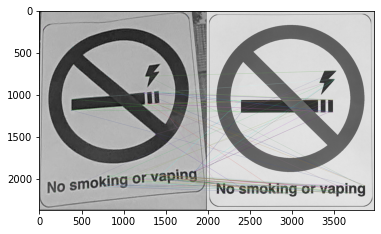

Dumb warp, gold Standard SSIM: 0.6655745750812718
Smart warp, gold Standard SSIM: 0.6564656702173771
Image smart-warped to feature matches: 


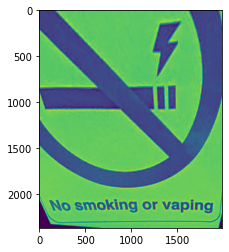

Transform from img-5.jpg to Gold:
Image before Warping: 


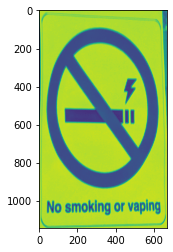

Image After dumb-warping, feature matched to gold standard: 


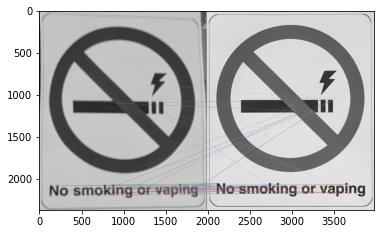

Dumb warp, gold Standard SSIM: 0.7401178728545131
Smart warp, gold Standard SSIM: 0.48930807466985426
Image smart-warped to feature matches: 


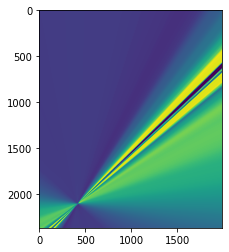

Transform from img-6.jpg to Gold:
Image before Warping: 


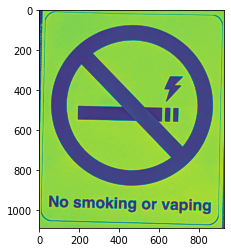

Image After dumb-warping, feature matched to gold standard: 


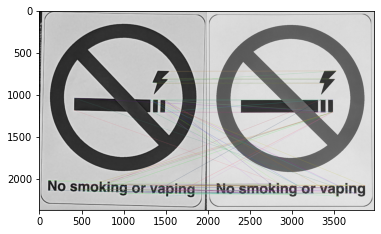

Dumb warp, gold Standard SSIM: 0.7341921661260176
Smart warp, gold Standard SSIM: 0.7739509033450968
Image smart-warped to feature matches: 


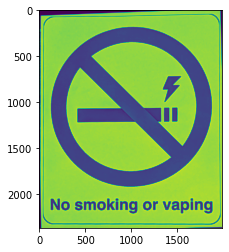

In [149]:
for ind, im in enumerate(greyIms):
  print(f"Transform from img-{ind + 1}.jpg to Gold:")
  print(f"Image before Warping: ")
  plt.imshow(im)
  plt.show()
  warpCorrected = dumbWarp(im, greyGold)
  print(f"Image After dumb-warping, feature matched to gold standard: ")
  res, homo = alignImagesORB(warpCorrected, greyGold)

  (dscore, diff) = structural_similarity(warpCorrected, greyGold, full=True)
  (ascore, diff) = structural_similarity(res, greyGold, full=True)
  print(f'Dumb warp, gold Standard SSIM: {dscore}')
  print(f'Smart warp, gold Standard SSIM: {ascore}')
  print(f"Image smart-warped to feature matches: ")
  plt.imshow(res)
  plt.show()